# TDSE - Heart Disease Risk Prediction: Logistic Regression Homework



In [ ]:
%pip install numpy pandas matplotlib 

## Step 1: Load and Prepare the Dataset

### Loading the Dataset and Target Encoding

The Heart Disease dataset was loaded from a CSV file downloaded from Kaggle. The dataset contains clinical information from 303 patients and a target variable indicating the presence or absence of heart disease.

The target column, originally stored as categorical values ("Presence" and "Absence"), was transformed into a binary numerical format to make it compatible with logistic regression. The values were mapped as follows:
- Presence → 1 (heart disease present)
- Absence → 0 (heart disease absent)

This binary encoding is required for the binary cross-entropy loss function used in logistic regression.


In [2]:
import pandas as pd

df = pd.read_csv("Heart_Disease_Prediction.csv")

df["Heart Disease"] = df["Heart Disease"].map({
    "Presence": 1,
    "Absence": 0
})


### Exploratory Data Analysis (EDA)

An initial exploratory analysis was performed to understand the structure and quality of the dataset. The `info()` method was used to inspect data types and detect missing values, while `describe()` provided summary statistics such as mean, standard deviation, and quartiles for numerical features.

This step helps identify potential data quality issues and provides an overview of feature distributions before further preprocessing.


In [3]:
def EDA():
    # Summarize stats
    df.info()

    # Descriptive statistics
    df.describe()

EDA()

<class 'pandas.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage

### Outlier Detection Using the Interquartile Range (IQR)

To identify potential outliers in the numerical features, the Interquartile Range (IQR) method was applied. For each feature, the first quartile (Q1), third quartile (Q3), and IQR (Q3 − Q1) were computed.

Values falling below Q1 − 1.5×IQR or above Q3 + 1.5×IQR were counted as outliers. This analysis helps highlight extreme values that may influence model training. In this case, outliers were identified but retained to preserve the natural variability present in real-world clinical data.


In [4]:
# Outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print(outliers)

Age                         0
Sex                         0
Chest pain type            20
BP                          9
Cholesterol                 5
FBS over 120               40
EKG results                 0
Max HR                      1
Exercise angina             0
ST depression               4
Slope of ST                 0
Number of vessels fluro    19
Thallium                    0
Heart Disease               0
dtype: int64


### Feature Selection and Class Separation

Six clinically relevant numerical features were selected for model training: Age, Cholesterol, Blood Pressure (BP), Maximum Heart Rate, ST Depression, and Number of Vessels observed by fluoroscopy. These features are commonly associated with cardiovascular risk.

The feature matrix `X` and target vector `y` were created accordingly. To enable a stratified train/test split without using external libraries, the dataset was separated into two subsets based on the target class (heart disease present and absent). Each subset was randomly shuffled to remove any ordering bias.


In [5]:
features = [
    "Age",
    "Cholesterol",
    "BP",
    "Max HR",
    "ST depression",
    "Number of vessels fluro",
]

X = df[features]

y = df["Heart Disease"]

df_0 = df[df["Heart Disease"] == 0]
df_1 = df[df["Heart Disease"] == 1]

df_0 = df_0.sample(frac=1, random_state=42)
df_1 = df_1.sample(frac=1, random_state=42)




### Stratified Train/Test Split and Feature Normalization

The dataset was split into training (70%) and testing (30%) sets using a stratified approach to preserve the original class distribution in both subsets. This ensures fair evaluation and prevents bias caused by class imbalance.

After splitting, the feature matrices and target vectors were extracted for both training and test sets. Feature normalization was then applied using Z-score standardization. The mean and standard deviation were computed exclusively from the training data and applied to both training and test sets.

This normalization step is essential for gradient descent optimization, as it ensures all features contribute proportionally during training and improves convergence stability. The resulting normalized training features have approximately zero mean and unit variance.


In [9]:
# Proporción de entrenamiento
train_ratio = 0.7

# Split por clase
train_0 = df_0.iloc[:int(len(df_0) * train_ratio)]
test_0  = df_0.iloc[int(len(df_0) * train_ratio):]

train_1 = df_1.iloc[:int(len(df_1) * train_ratio)]
test_1  = df_1.iloc[int(len(df_1) * train_ratio):]

# Unir clases
train_df = pd.concat([train_0, train_1]).sample(frac=1, random_state=42)
test_df  = pd.concat([test_0, test_1]).sample(frac=1, random_state=42)

# Separar X e y
X_train = train_df[features].values
y_train = train_df["Heart Disease"].values

X_test = test_df[features].values
y_test = test_df["Heart Disease"].values

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Calcular media y desviación estándar del train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# Normalizar
X_train_norm = (X_train - mean) / std
X_test_norm = (X_test - mean) / std

print("Mean (train):", X_train_norm.mean(axis=0))
print("Std (train):", X_train_norm.std(axis=0))


Train size: (189, 6)
Test size: (81, 6)
Mean (train): [ 1.90323947e-16  1.73876199e-16  3.19556257e-16  2.70213011e-16
  9.39871344e-17 -5.63922806e-17]
Std (train): [1. 1. 1. 1. 1. 1.]


## Step 2: Implement Basic Logistic Regression

### Sigmoid Function and Cost Function

This cell defines the core mathematical components of logistic regression. The sigmoid function is used to map the linear model output into a probability value between 0 and 1.

The cost function implements binary cross-entropy loss, which measures how well the predicted probabilities match the true binary labels. To ensure numerical stability, a small epsilon value is added to prevent undefined logarithmic operations when probabilities approach 0 or 1.

This cost function serves as the objective function minimized during training.


In [ ]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, w, b):
    m = X.shape[0]
    z = X @ w + b
    y_hat = sigmoid(z)

    # Evitar log(0)
    epsilon = 1e-8
    cost = -(1/m) * np.sum(
        y * np.log(y_hat + epsilon) +
        (1 - y) * np.log(1 - y_hat + epsilon)
    )

    return cost


### Gradient Descent Implementation

This cell implements the gradient descent algorithm to optimize the logistic regression parameters. At each iteration, predictions are computed using the sigmoid function, and gradients of the cost function with respect to the weights and bias are calculated.

The weights and bias are updated iteratively using the learning rate (α). The cost value is recorded at each iteration to monitor convergence. Printing the cost every 100 iterations allows tracking of training progress and helps verify that the optimization is working correctly.


In [11]:
def gradient_descent(X, y, w, b, alpha, num_iters):
    m = X.shape[0]
    cost_history = []

    for i in range(num_iters):
        z = X @ w + b
        y_hat = sigmoid(z)

        dw = (1/m) * (X.T @ (y_hat - y))
        db = (1/m) * np.sum(y_hat - y)

        w = w - alpha * dw
        b = b - alpha * db

        cost = compute_cost(X, y, w, b)
        cost_history.append(cost)

        if i % 100 == 0:
            print(f"Iteration {i}: Cost {cost:.4f}")

    return w, b, cost_history


### Model Training

The logistic regression model is trained using the full normalized training dataset. All weights are initialized to zero, and the bias term is set to zero.

A learning rate of 0.01 and 1000 training iterations were selected to ensure stable convergence. The gradient descent function returns the optimized weights, bias, and the history of cost values across iterations, which are later used for convergence analysis.


In [12]:
# Inicialización
n_features = X_train_norm.shape[1]
w_init = np.zeros(n_features)
b_init = 0

alpha = 0.01
iterations = 1000

w_final, b_final, cost_history = gradient_descent(
    X_train_norm, y_train,
    w_init, b_init,
    alpha, iterations
)


Iteration 0: Cost 0.6914
Iteration 100: Cost 0.5763
Iteration 200: Cost 0.5259
Iteration 300: Cost 0.4993
Iteration 400: Cost 0.4834
Iteration 500: Cost 0.4728
Iteration 600: Cost 0.4654
Iteration 700: Cost 0.4598
Iteration 800: Cost 0.4556
Iteration 900: Cost 0.4523


### Training Convergence Visualization

This plot visualizes the evolution of the cost function across training iterations. A consistently decreasing cost indicates successful convergence of the gradient descent algorithm.

The smooth downward trend suggests that the learning rate was appropriately chosen and that feature normalization contributed to stable optimization behavior.


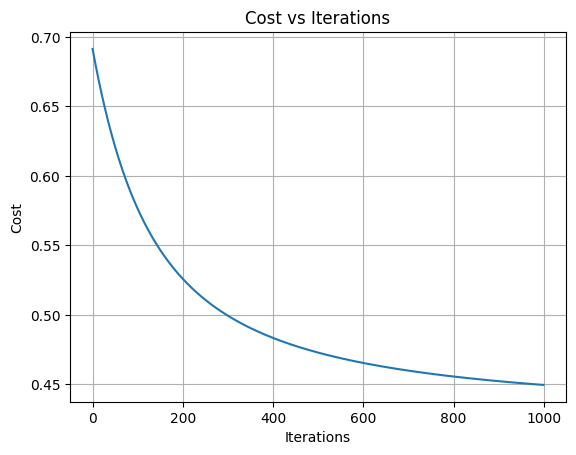

In [13]:
import matplotlib.pyplot as plt

plt.plot(cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost vs Iterations")
plt.grid(True)
plt.show()


### Prediction and Evaluation Metrics

This cell defines functions for generating class predictions and evaluating model performance. Predicted probabilities are converted into binary class labels using a threshold of 0.5.

Model performance is assessed using accuracy, precision, recall, and F1-score. These metrics provide a comprehensive evaluation, particularly for medical classification problems where false positives and false negatives have different implications.


In [15]:
def predict(X, w, b, threshold=0.5):
    probs = sigmoid(X @ w + b)
    return (probs >= threshold).astype(int)

def compute_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return accuracy, precision, recall, f1



### Model Evaluation

The trained logistic regression model is evaluated on both the training and test datasets. Predictions are generated using the learned weights and bias, and evaluation metrics are computed for each dataset.

Comparing performance across training and test sets allows assessment of the model’s generalization ability and detection of potential overfitting.


In [16]:
# Predictions
y_train_pred = predict(X_train_norm, w_final, b_final)
y_test_pred = predict(X_test_norm, w_final, b_final)

# Metrics
train_metrics = compute_metrics(y_train, y_train_pred)
test_metrics = compute_metrics(y_test, y_test_pred)

train_metrics, test_metrics


((np.float64(0.8042328042328042),
  np.float64(0.813333333224889),
  np.float64(0.726190476104025),
  np.float64(0.7672955924037816)),
 (np.float64(0.7654320987654321),
  np.float64(0.8148148145130315),
  np.float64(0.6111111109413581),
  np.float64(0.698412693293021)))

### Performance Metrics Summary

The evaluation metrics for both the training and test sets are summarized in a table for easy comparison. This structured presentation highlights differences in performance across datasets and facilitates interpretation of model effectiveness.

Consistent metrics between training and test sets indicate good generalization, while large discrepancies may suggest overfitting or underfitting.


In [17]:
metrics_df = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Accuracy": [train_metrics[0], test_metrics[0]],
    "Precision": [train_metrics[1], test_metrics[1]],
    "Recall": [train_metrics[2], test_metrics[2]],
    "F1-score": [train_metrics[3], test_metrics[3]]
})

metrics_df


,Dataset,Accuracy,Precision,Recall,F1-score
0,Train,0.804233,0.813333,0.726190,0.767296
1,Test,0.765432,0.814815,0.611111,0.698413


## Step 3: Visualize Decision Boundaries

### Decision Boundary Visualization Function

This cell defines a helper function to visualize the decision boundary of a logistic regression model using two features at a time. The selected feature pair is first normalized using Z-score standardization to ensure stable optimization.

A new logistic regression model is trained using only the two selected features. After training, the decision boundary is derived analytically from the learned parameters, based on the condition where the predicted probability equals 0.5.

The function then plots a scatter diagram of the true class labels along with the learned linear decision boundary, enabling visual inspection of class separability.


In [ ]:
def plot_decision_boundary(X, y, feature_names, alpha=0.01, iterations=1000):
    # Normalization
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X_norm = (X - mean) / std

    # Inicialization
    w = np.zeros(2)
    b = 0

    # Train
    w, b, _ = gradient_descent(X_norm, y, w, b, alpha, iterations)

    # Scatter plot
    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", alpha=0.7)
    
    # Decision boundary
    x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x_vals_norm = (x_vals - mean[0]) / std[0]
    y_vals_norm = -(w[0] * x_vals_norm + b) / w[1]
    y_vals = y_vals_norm * std[1] + mean[1]

    plt.plot(x_vals, y_vals, color="black", linewidth=2)

    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(f"Decision Boundary: {feature_names[0]} vs {feature_names[1]}")
    plt.grid(True)
    plt.show()



### Decision Boundary: Age vs Cholesterol

This visualization explores the relationship between patient age and cholesterol level in predicting heart disease. The logistic regression model is trained using only these two features, and the resulting decision boundary is plotted.

The scatter plot reveals partial separability between the two classes. Higher cholesterol levels, particularly in older patients, are generally associated with increased heart disease risk. However, significant overlap between classes indicates that this feature pair alone does not provide perfect linear separation.


Iteration 0: Cost 0.6930
Iteration 100: Cost 0.6811
Iteration 200: Cost 0.6743
Iteration 300: Cost 0.6704
Iteration 400: Cost 0.6681
Iteration 500: Cost 0.6667
Iteration 600: Cost 0.6658
Iteration 700: Cost 0.6653
Iteration 800: Cost 0.6650
Iteration 900: Cost 0.6648


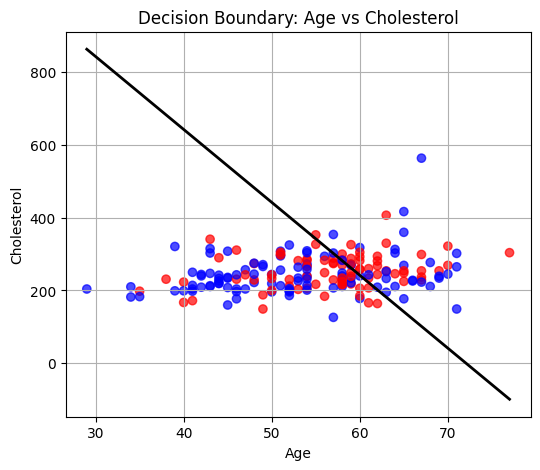

In [23]:
pair1 = ["Age", "Cholesterol"]
X_pair1 = train_df[pair1].values
y_pair1 = train_df["Heart Disease"].values

plot_decision_boundary(X_pair1, y_pair1, pair1)

### Decision Boundary: Blood Pressure vs Maximum Heart Rate

This plot examines how blood pressure and maximum heart rate interact in distinguishing patients with and without heart disease. The learned decision boundary suggests that patients with higher blood pressure and lower maximum heart rate tend to have a higher predicted risk.

Despite a visible trend, the overlap between classes suggests nonlinearity and highlights the need for additional features to improve classification performance.


Iteration 0: Cost 0.6926
Iteration 100: Cost 0.6504
Iteration 200: Cost 0.6249
Iteration 300: Cost 0.6090
Iteration 400: Cost 0.5988
Iteration 500: Cost 0.5922
Iteration 600: Cost 0.5877
Iteration 700: Cost 0.5847
Iteration 800: Cost 0.5826
Iteration 900: Cost 0.5811


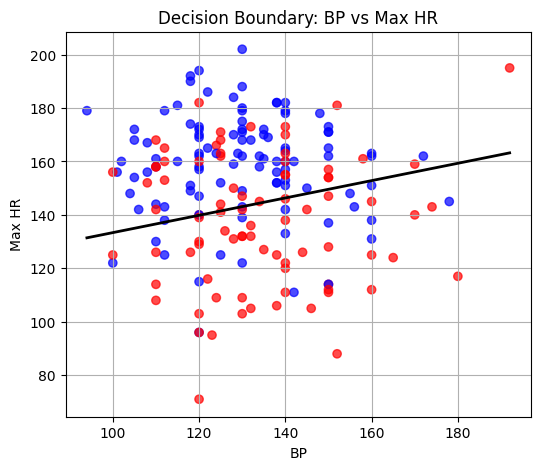

In [21]:
pair2 = ["BP", "Max HR"]
X_pair2 = train_df[pair2].values
y_pair2 = train_df["Heart Disease"].values

plot_decision_boundary(X_pair2, y_pair2, pair2)

### Decision Boundary: ST Depression vs Number of Vessels

This feature pair shows stronger class separability compared to the previous combinations. Higher values of ST depression and a greater number of affected vessels are strongly associated with the presence of heart disease.

The resulting decision boundary provides a clearer division between classes, indicating that these features are particularly informative for heart disease risk prediction.


Iteration 0: Cost 0.6920
Iteration 100: Cost 0.6074
Iteration 200: Cost 0.5612
Iteration 300: Cost 0.5340
Iteration 400: Cost 0.5170
Iteration 500: Cost 0.5059
Iteration 600: Cost 0.4983
Iteration 700: Cost 0.4930
Iteration 800: Cost 0.4892
Iteration 900: Cost 0.4864


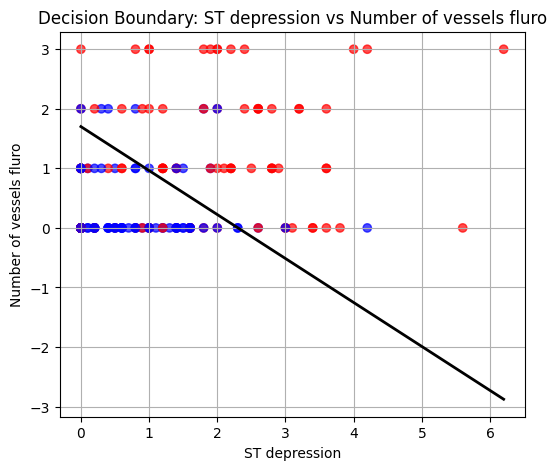

In [24]:
pair3 = ["ST depression", "Number of vessels fluro"]
X_pair3 = train_df[pair3].values
y_pair3 = train_df["Heart Disease"].values

plot_decision_boundary(X_pair3, y_pair3, pair3)


## Step 4: Repeat with Regularization

## Regularized Cost Function
This function computes the **logistic regression cost with L2 regularization**.

First, it calculates the linear combination `z = Xw + b` and applies the sigmoid
to obtain predicted probabilities.  
Then, it computes the standard **logistic loss**, adding a small epsilon to avoid
numerical issues with `log(0)`.

Finally, it adds the **L2 regularization term**, which penalizes large weights
using `λ / (2m) * ||w||²`.  
The returned value is the total regularized cost.

In [25]:
def compute_cost_reg(X, y, w, b, lambda_):
    m = X.shape[0]
    z = X @ w + b
    y_hat = sigmoid(z)

    epsilon = 1e-8
    logistic_cost = -(1/m) * np.sum(
        y * np.log(y_hat + epsilon) +
        (1 - y) * np.log(1 - y_hat + epsilon)
    )

    reg_cost = (lambda_ / (2 * m)) * np.sum(w ** 2)

    return logistic_cost + reg_cost


## Gradient Descent with L2 Regularization
This function performs **gradient descent for logistic regression with L2 regularization**.

At each iteration, predictions are computed using the sigmoid function.
The gradient for the weights includes both:
- the data-driven gradient, and
- the L2 penalty term `(λ/m) * w`.

The bias gradient is not regularized.
Weights and bias are updated using the learning rate `alpha`,
and the cost is stored at each iteration for later analysis.

In [26]:
def gradient_descent_reg(X, y, w, b, alpha, num_iters, lambda_):
    m = X.shape[0]
    cost_history = []

    for i in range(num_iters):
        z = X @ w + b
        y_hat = sigmoid(z)

        dw = (1/m) * (X.T @ (y_hat - y)) + (lambda_ / m) * w
        db = (1/m) * np.sum(y_hat - y)

        w = w - alpha * dw
        b = b - alpha * db

        cost = compute_cost_reg(X, y, w, b, lambda_)
        cost_history.append(cost)

    return w, b, cost_history


## Training with Different λ Values
Here, multiple values of the regularization parameter `λ` are tested.

For each λ:
- the model is initialized from scratch,
- trained using regularized gradient descent,
- evaluated on both training and test sets.

Accuracy, F1-score, and the L2 norm of the weight vector `||w||`
are stored to analyze performance and model complexity trade-offs.

In [ ]:
lambdas = [0, 0.001, 0.01, 0.1, 1]

results = []

for lam in lambdas:
    w = np.zeros(X_train_norm.shape[1])
    b = 0

    w, b, cost_hist = gradient_descent_reg(
        X_train_norm, y_train,
        w, b,
        alpha=0.01,
        num_iters=1000,
        lambda_=lam
    )

    # Predictions
    y_train_pred = predict(X_train_norm, w, b)
    y_test_pred = predict(X_test_norm, w, b)

    train_metrics = compute_metrics(y_train, y_train_pred)
    test_metrics = compute_metrics(y_test, y_test_pred)

    weight_norm = np.linalg.norm(w)

    results.append([
        lam,
        train_metrics[0], test_metrics[0],
        train_metrics[3], test_metrics[3],
        weight_norm
    ])


## Results Table
This cell organizes the results into a Pandas DataFrame.

Each row corresponds to a different value of `λ`,
showing training and test performance along with the weight norm.

The table helps identify the **optimal λ** that balances
generalization performance and weight magnitude.

In [28]:
lambda_df = pd.DataFrame(
    results,
    columns=[
        "Lambda",
        "Train Accuracy",
        "Test Accuracy",
        "Train F1",
        "Test F1",
        "||w||"
    ]
)

lambda_df


,Lambda,Train Accuracy,Test Accuracy,Train F1,Test F1,||w||
0,0.000,0.804233,0.765432,0.767296,0.698413,1.238969
1,0.001,0.804233,0.765432,0.767296,0.698413,1.238944
2,0.010,0.804233,0.765432,0.767296,0.698413,1.238718
3,0.100,0.804233,0.765432,0.767296,0.698413,1.236462
4,1.000,0.798942,0.765432,0.759494,0.698413,1.214333


## Cost Comparison (Regularized vs Unregularized)
This cell compares the **training cost evolution** with and without L2 regularization.

First, the model is trained without regularization (λ = 0).
Then, it is trained again using the selected optimal λ.

Both cost curves are plotted to visualize how regularization
affects convergence speed and stability during training.

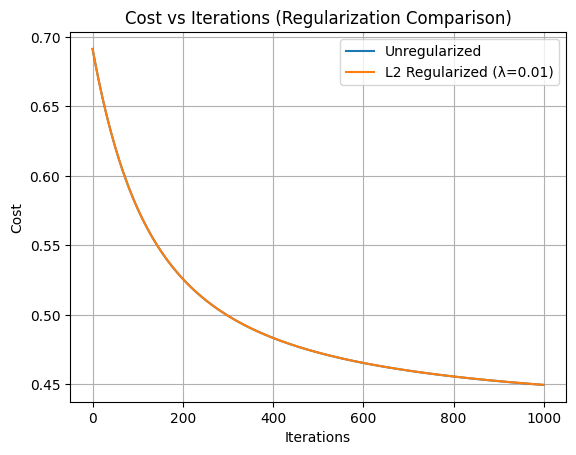

In [ ]:
# Unregularized
_, _, cost_unreg = gradient_descent_reg(
    X_train_norm, y_train,
    np.zeros(X_train_norm.shape[1]), 0,
    alpha=0.01, num_iters=1000, lambda_=0
)

# Regularized
lambda_opt = 0.01
_, _, cost_reg = gradient_descent_reg(
    X_train_norm, y_train,
    np.zeros(X_train_norm.shape[1]), 0,
    alpha=0.01, num_iters=1000, lambda_=lambda_opt
)

plt.plot(cost_unreg, label="Unregularized")
plt.plot(cost_reg, label=f"L2 Regularized (λ={lambda_opt})")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost vs Iterations (Regularization Comparison)")
plt.legend()
plt.grid(True)
plt.show()


## Decision Boundary Comparison
This function visualizes the effect of L2 regularization
on the **decision boundary** using two features.

The data is normalized, and two models are trained:
one without regularization and one with L2 regularization.

Both decision boundaries are plotted on the same figure,
showing how regularization typically produces
smoother and less extreme boundaries.

In [ ]:
def plot_boundary_comparison(X, y, feature_names, lambda_):
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X_norm = (X - mean) / std

    # Unregularized
    w0, b0, _ = gradient_descent_reg(
        X_norm, y, np.zeros(2), 0,
        alpha=0.01, num_iters=1000, lambda_=0
    )

    # Regularized
    w1, b1, _ = gradient_descent_reg(
        X_norm, y, np.zeros(2), 0,
        alpha=0.01, num_iters=1000, lambda_=lambda_
    )

    plt.figure(figsize=(6, 5))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", alpha=0.6)

    x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x_norm = (x_vals - mean[0]) / std[0]

    y0 = (-(w0[0] * x_norm + b0) / w0[1]) * std[1] + mean[1]
    y1 = (-(w1[0] * x_norm + b1) / w1[1]) * std[1] + mean[1]

    plt.plot(x_vals, y0, "k--", label="Unregularized")
    plt.plot(x_vals, y1, "k", label=f"L2 (λ={lambda_})")

    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title("Decision Boundary Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()


## Applying Boundary Comparison to a Feature Pair
In this cell, a specific pair of features is selected
to analyze the decision boundary behavior.

The function `plot_boundary_comparison` is called using the
chosen feature pair and the optimal λ value.

This provides a visual comparison of how L2 regularization
improves model generalization for a real feature subset.

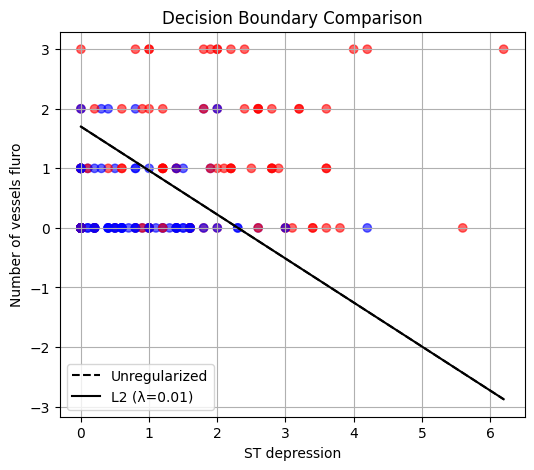

In [31]:
pair = ["ST depression", "Number of vessels fluro"]
X_pair = train_df[pair].values
y_pair = train_df["Heart Disease"].values

plot_boundary_comparison(X_pair, y_pair, pair, lambda_opt)
